In [1]:
__imp

Libraries have been loaded


### Load Additional Libraries

In [3]:
import time
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score

from bayes_opt import BayesianOptimization

basepath = os.path.expanduser('../')

from tqdm import tqdm_notebook

Load Raw Dataset

In [4]:
%%time

# contains feature pertaining to raw application file
train = pd.read_pickle('../data/interim/feature_groups/application_train.pkl')
test  = pd.read_pickle('../data/interim/feature_groups/application_test.pkl')

print(train.shape, test.shape)
del train, test
gc.collect();

(307511, 122) (48744, 122)
CPU times: user 46.7 ms, sys: 148 ms, total: 194 ms
Wall time: 2.04 s


In [ ]:
%%time

data       = pd.concat((train, test))
data.index = np.arange(len(data))

Load Processed Dataset

In [3]:
%%time

data = pd.read_hdf('../data/interim/dataset2/data.h5', key='data')

CPU times: user 4.76 s, sys: 1.14 s, total: 5.91 s
Wall time: 15.2 s


## Adversarial Validation

In [5]:
for c in data.select_dtypes(include=['category']).columns:
    data[c] = data[c].cat.codes

In [6]:
data['is_test'] = 1
data['is_test'].iloc[:307511] = 0

In [7]:
SKIP_FLDS = ['SK_ID_CURR', 'TARGET', 'is_test']

df, y = data.loc[:, data.columns.drop(SKIP_FLDS)], data.loc[:, 'is_test']

In [8]:
X_train, X_val, y_train, y_val = train_test_split(df, y, random_state=SEED, test_size=.3)

In [10]:
del df, y, data
gc.collect();

In [15]:
params = {
    'objective': 'binary',
    'learning_rate': .1,
    'num_leaves': 20,
    'min_data_in_leaf': 75,
    'metric': 'auc',
    'nthread': 4,
    'seed': SEED
}

num_boost_round       = 10000
early_stopping_rounds = 100

ltrain = lgb.Dataset(X_train, y_train, feature_name=X_train.columns.tolist())
lval   = lgb.Dataset(X_val, y_val, feature_name=X_val.columns.tolist())

val_sets  = [ltrain, lval]
val_names = ['train', 'eval'] 

m      = lgb.train(params, 
                   ltrain, 
                   num_boost_round, 
                   valid_sets=val_sets, 
                   valid_names=val_names, 
                   early_stopping_rounds=early_stopping_rounds,
                   verbose_eval=20
                  )

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.959119	eval's auc: 0.958474
[40]	train's auc: 0.965849	eval's auc: 0.964612
[60]	train's auc: 0.970606	eval's auc: 0.968958
[80]	train's auc: 0.973969	eval's auc: 0.971971
[100]	train's auc: 0.976065	eval's auc: 0.973746
[120]	train's auc: 0.977772	eval's auc: 0.975032
[140]	train's auc: 0.979204	eval's auc: 0.97606
[160]	train's auc: 0.980475	eval's auc: 0.976939
[180]	train's auc: 0.981491	eval's auc: 0.977471
[200]	train's auc: 0.982375	eval's auc: 0.977978
[220]	train's auc: 0.983106	eval's auc: 0.978119
[240]	train's auc: 0.983793	eval's auc: 0.978352
[260]	train's auc: 0.984499	eval's auc: 0.978603
[280]	train's auc: 0.985088	eval's auc: 0.97873
[300]	train's auc: 0.985713	eval's auc: 0.978906
[320]	train's auc: 0.986262	eval's auc: 0.979015
[340]	train's auc: 0.986933	eval's auc: 0.979315
[360]	train's auc: 0.987507	eval's auc: 0.979502
[380]	train's auc: 0.987963	eval's auc: 0.979576
[400]	train'

In [22]:
m.save_model('../data/processed/models/adversarial_model_subset.txt')

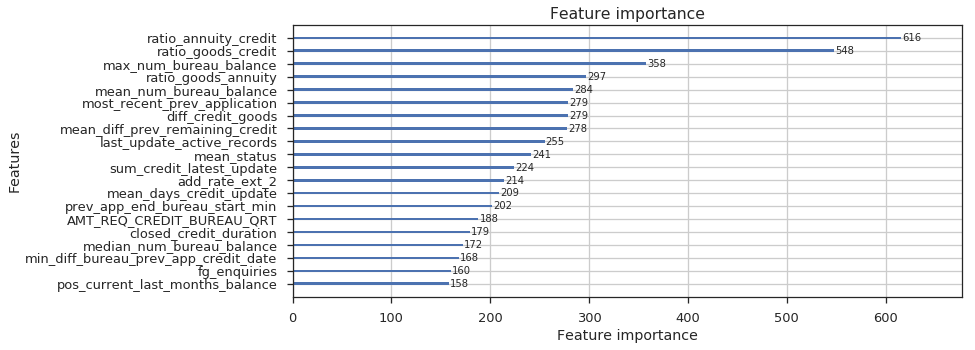

In [23]:
fig, ax = plt.subplots(1, figsize=(12, 5))
lgb.plot_importance(m, importance_type='split', max_num_features=20, ax=ax);

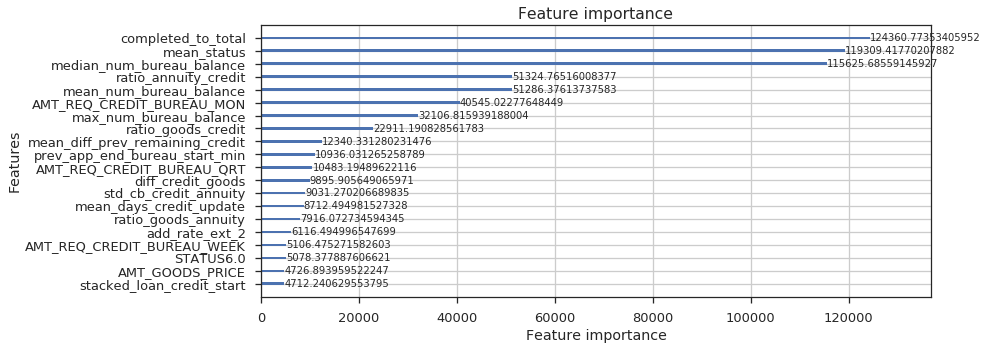

In [16]:
fig, ax = plt.subplots(1, figsize=(12, 5))
lgb.plot_importance(m, importance_type='gain', max_num_features=20, ax=ax);

### OOF prediction for training set

In [5]:
SKIP_FLDS = ['SK_ID_CURR', 'TARGET', 'is_test']

data['is_test'] = 1
data['is_test'].iloc[:303576] = 0

data  = data.sample(frac=1.) # shuffle rows
df, y = data.loc[:, data.columns.drop(SKIP_FLDS)], data.loc[:, 'is_test']

In [6]:
%%time

estimator  = lgb.LGBMClassifier(n_estimators=2015, max_depth=4, objective='binary')
oof_scores = cross_val_predict(estimator, df, y, cv=5, method='predict_proba')

CPU times: user 2h 51min 43s, sys: 22 s, total: 2h 52min 5s
Wall time: 44min 51s


In [7]:
np.save('../data/processed/models/oof_scores_sub.npy', oof_scores)

In [6]:
oof_scores = np.load('../data/processed/models/oof_scores.npy')

In [8]:
df_copy                        = df.copy()
df_copy.loc[:, 'is_test_prob'] = oof_scores[:, 1]
df_copy.loc[:, 'is_test']      = y
df_copy.loc[:, 'SK_ID_CURR']   = data.SK_ID_CURR

target                         = data.TARGET.iloc[:303576]

In [9]:
del data
gc.collect()

82

In [10]:
df_copy[df_copy.is_test == 0].sort_values(by='is_test_prob', ascending=False)\
                             .loc[:, ['SK_ID_CURR', 'is_test_prob']]

,SK_ID_CURR,is_test_prob
72358,185021,9.999868e-01
131849,254911,9.974637e-01
176317,307008,9.966514e-01
163651,292206,9.949051e-01
252925,396519,9.937778e-01
59929,170445,9.932063e-01
167459,296636,9.931919e-01
107132,225900,9.925747e-01
66538,178204,9.920861e-01
120631,241677,9.918937e-01


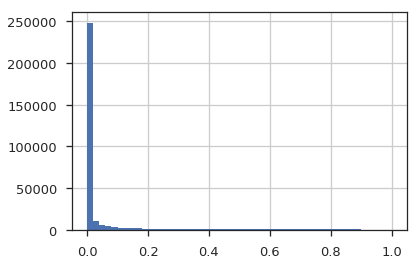

In [11]:
df_copy[df_copy.is_test == 0].is_test_prob.hist(bins=50);

In [77]:
def fold_gen(df_copy):
    x = df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob > .15)]

    for fold in range(5):
        test_index  = list(x.sample(frac=48744).index)
        train_index = list(set(df_copy[(df_copy.is_test == 0)].index) - set(test_index))

        yield train_index,  test_index

In [12]:
df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob > .4)].shape[0]

12798

In [13]:
df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob <= 0.3)].shape[0]

286674

In [24]:
16668 / 307511

0.05420293908185398

In [26]:
.2 * 48744

9748.800000000001

In [20]:
def save_folds(df_copy):
    x = df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob > .3)]
    test_folds = []
    
    for fold in range(6):
        test_index  = list(x.sample(n=9748).index)
        train_index = list(set(df_copy[(df_copy.is_test == 0)].index) - set(test_index))

        test_folds.append(test_index)
    
    test_folds = np.array(test_folds).T
    cv_df      = pd.DataFrame(test_folds, columns=[f'F{i}' for i in range(6)])
    
    cv_df.to_csv('../data/raw/cv_adversarial_idx_sub_v1.csv', index=False)
#     return cv_df

In [34]:
save_folds(df_copy)

In [15]:
cv_folds = save_folds(df_copy)

In [16]:
len((set(cv_folds['F0'].values) & set(cv_folds['F2'].values))) / len(cv_folds['F0'])

0.5820681165367255

In [17]:
len((set(cv_folds['F0'].values) & set(cv_folds['F3'].values))) / len(cv_folds['F0'])

0.5770414443988511

In [32]:
len((set(cv_folds['F0'].values) & set(cv_folds['F4'].values))) / len(cv_folds['F0'])

0.5860689372178909

In [18]:
len((set(cv_folds['F0'].values) & set(cv_folds['F1'].values))) / len(cv_folds['F0'])

0.5798112433319655

In [19]:
df_copy.shape

(352321, 710)

In [82]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'seed': SEED
}

num_boost_round       = 500
early_stopping_rounds = 100

ltrain = lgb.Dataset(df.iloc[:len(train)].copy(), TARGET, feature_name=df.columns.tolist())

lgb.cv(params, 
       ltrain, 
       num_boost_round, 
       folds=fold_gen(df_copy), 
       early_stopping_rounds=early_stopping_rounds, 
       verbose_eval=20)

[20]	cv_agg's auc: 0.618144 + 0.00514626
[40]	cv_agg's auc: 0.631824 + 0.0046029
[60]	cv_agg's auc: 0.63968 + 0.00515748
[80]	cv_agg's auc: 0.64062 + 0.00485862
[100]	cv_agg's auc: 0.642104 + 0.00573209
[120]	cv_agg's auc: 0.642286 + 0.00572781
[140]	cv_agg's auc: 0.642618 + 0.00600976
[160]	cv_agg's auc: 0.642657 + 0.00613822
[180]	cv_agg's auc: 0.642169 + 0.0060855
[200]	cv_agg's auc: 0.64151 + 0.00599734
[220]	cv_agg's auc: 0.641801 + 0.0057658
[240]	cv_agg's auc: 0.642513 + 0.00623979
[260]	cv_agg's auc: 0.64221 + 0.00644424


{'auc-mean': [0.6042937582096902,
  0.6063851080102118,
  0.6094948735497355,
  0.6105071593059883,
  0.6103113565861819,
  0.609949146327001,
  0.6112450210864804,
  0.611922664355651,
  0.6130385780092173,
  0.6135514649349239,
  0.6140567851372335,
  0.6138722483547333,
  0.6138905358882123,
  0.6144706221804735,
  0.6154927026924676,
  0.6163287187043333,
  0.616554768416919,
  0.6173352621591126,
  0.6174060247445852,
  0.6181444201569033,
  0.6187143963227383,
  0.6194944579588235,
  0.6198957050849789,
  0.6207915448273522,
  0.6219778419869648,
  0.6230271612099727,
  0.6237795045767934,
  0.6248345699284803,
  0.6255729154444939,
  0.626186580135842,
  0.6268817748326054,
  0.6272010226809934,
  0.6273822084294582,
  0.6275895204726845,
  0.6282070344389259,
  0.6287205101248088,
  0.6293304442291344,
  0.6304520246260321,
  0.6314348211934767,
  0.63182393503278,
  0.6320910920507157,
  0.6328286905792679,
  0.6332499251145899,
  0.6335400030841262,
  0.6339219347473423,
  0.

## Feature Selection

In [5]:
SKIP_FLDS                      = ['SK_ID_CURR', 'TARGET']

df, y                          = data.iloc[:307511].loc[:, data.columns.drop(SKIP_FLDS)], data.iloc[:307511].loc[:, 'TARGET']
X_train, X_val, y_train, y_val = train_test_split(df, y, random_state=SEED, test_size=.3)

In [12]:
params = {
    'objective': 'binary',
    'learning_rate': 0.02,
    'metric': 'auc',
    'max_depth': 6,
    'sub_feature': .05,
    'reg_lambda': 100,
    'num_leaves': 30,
    'min_data_in_leaf': 100,
    'feature_fraction_seed': SEED,
    'min_data_in_leaf': 100,
    'max_bin': 300,
    'reg_lambda': 100,
    'nthread': 4,
    'verbose': -1,
    'seed': SEED
}

num_boost_round       = 10000
early_stopping_rounds = 100

ltrain = lgb.Dataset(X_train, y_train, feature_name=X_train.columns.tolist())
lval   = lgb.Dataset(X_val, y_val, feature_name=X_val.columns.tolist())

val_sets  = [ltrain, lval]
val_names = ['train', 'eval'] 

m      = lgb.train(params, 
                   ltrain, 
                   num_boost_round, 
                   valid_sets=val_sets, 
                   valid_names=val_names, 
                   early_stopping_rounds=early_stopping_rounds,
                   verbose_eval=20
                  )

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.753514	eval's auc: 0.743248
[40]	train's auc: 0.760975	eval's auc: 0.749357
[60]	train's auc: 0.764638	eval's auc: 0.751588
[80]	train's auc: 0.76911	eval's auc: 0.754965
[100]	train's auc: 0.772924	eval's auc: 0.757673
[120]	train's auc: 0.775898	eval's auc: 0.759636
[140]	train's auc: 0.779077	eval's auc: 0.76191
[160]	train's auc: 0.7821	eval's auc: 0.764041
[180]	train's auc: 0.784601	eval's auc: 0.765846
[200]	train's auc: 0.787142	eval's auc: 0.767497
[220]	train's auc: 0.789478	eval's auc: 0.769111
[240]	train's auc: 0.791481	eval's auc: 0.770514
[260]	train's auc: 0.793569	eval's auc: 0.771994
[280]	train's auc: 0.795471	eval's auc: 0.77316
[300]	train's auc: 0.797254	eval's auc: 0.774265
[320]	train's auc: 0.798912	eval's auc: 0.775219
[340]	train's auc: 0.800393	eval's auc: 0.77598
[360]	train's auc: 0.801907	eval's auc: 0.776758
[380]	train's auc: 0.803453	eval's auc: 0.777704
[400]	train's au

[3320]	train's auc: 0.885139	eval's auc: 0.7928
[3340]	train's auc: 0.885479	eval's auc: 0.792798
[3360]	train's auc: 0.885814	eval's auc: 0.792752
[3380]	train's auc: 0.886105	eval's auc: 0.792733
[3400]	train's auc: 0.886396	eval's auc: 0.792724
Early stopping, best iteration is:
[3302]	train's auc: 0.884891	eval's auc: 0.792815


In [13]:
feat_imp = pd.DataFrame({'feat': m.feature_name(), 'imp': m.feature_importance(importance_type='gain')})\
             .sort_values(by='imp', ascending=False)

In [20]:
feat_imp[feat_imp['imp'] < 43].feat.tolist()

['NAME_GOODS_CATEGORY_6',
 'NAME_EDUCATION_TYPE__2',
 'NAME_HOUSING_TYPE__1',
 'FONDKAPREMONT_MODE',
 'STATUS1.0',
 'FLAG_DOCUMENT_6',
 'num_high_int_no_info_loans',
 'NUM_NULLS_EXT_SCORES',
 'STATUS3.0',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'FLAG_PHONE',
 'NAME_INCOME_TYPE__7',
 'OCCUPATION_TYPE__10',
 'STATUS2.0',
 'OCCUPATION_TYPE__-1',
 'OCCUPATION_TYPE__6',
 'OCCUPATION_TYPE__14',
 'NAME_INCOME_TYPE__1',
 'OCCUPATION_TYPE__3',
 'STATUS5.0',
 'ORGANIZATION_TYPE__31',
 'LIVE_REGION_NOT_WORK_REGION',
 'PRODUCT_COMBINATION_15',
 'FLAG_EMAIL',
 'sum_CODE_GENDER_NAME_EDUCATION_TYPE_OWN_CAR_AGE',
 'OCCUPATION_TYPE__0',
 'REG_REGION_NOT_WORK_REGION',
 'sum_num_times_prolonged',
 'total_cash_credit_dpd',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'ORGANIZATION_TYPE__11',
 'HOUSETYPE_MODE',
 'OCCUPATION_TYPE__8',
 'EMERGENCYSTATE_MODE',
 'ORGANIZATION_TYPE__55',
 'NAME_GOODS_CATEGORY_3',
 'ORGANIZATION_TYPE__33',
 'FLAG_DOCUMENT_5',
 'ORGANIZATION_TYPE__28',
 'ORGANIZATION_TYPE__51',
 'NAME_GOODS_CATEGORY_2

### Shuffle target

In [15]:
SKIP_FLDS                      = ['SK_ID_CURR', 'TARGET']

df, y                          = data.iloc[:307511].loc[:, data.columns.drop(SKIP_FLDS)], data.iloc[:307511].loc[:, 'TARGET']
y = y.sample(frac=1.)
X_train, X_val, y_train, y_val = train_test_split(df, y, random_state=SEED, test_size=.3)

In [16]:
params = {
    'objective': 'binary',
    'learning_rate': 0.02,
    'metric': 'auc',
    'max_depth': 6,
    'sub_feature': .05,
    'reg_lambda': 100,
    'num_leaves': 30,
    'min_data_in_leaf': 100,
    'feature_fraction_seed': SEED,
    'min_data_in_leaf': 100,
    'max_bin': 300,
    'reg_lambda': 100,
    'nthread': 4,
    'verbose': -1,
    'seed': SEED
}

num_boost_round       = 10000
early_stopping_rounds = 100

ltrain = lgb.Dataset(X_train, y_train, feature_name=X_train.columns.tolist())
lval   = lgb.Dataset(X_val, y_val, feature_name=X_val.columns.tolist())

val_sets  = [ltrain, lval]
val_names = ['train', 'eval'] 

m      = lgb.train(params, 
                   ltrain, 
                   num_boost_round, 
                   valid_sets=val_sets, 
                   valid_names=val_names, 
                   early_stopping_rounds=early_stopping_rounds,
                   verbose_eval=20
                  )

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.620242	eval's auc: 0.504715
[40]	train's auc: 0.643405	eval's auc: 0.507732
[60]	train's auc: 0.659297	eval's auc: 0.506849
[80]	train's auc: 0.669136	eval's auc: 0.50663
[100]	train's auc: 0.677299	eval's auc: 0.50754
Early stopping, best iteration is:
[2]	train's auc: 0.54556	eval's auc: 0.508101


In [17]:
feat_imp_shuffled = pd.DataFrame({
            'feat': m.feature_name(), 
            'imp': m.feature_importance(importance_type='gain')
})\
             .sort_values(by='imp', ascending=False)

In [18]:
feat_imp_shuffled

,feat,imp
26,DAYS_REGISTRATION,42.132000
229,latest_credit,27.934580
175,phone_to_birth_ratio,24.029550
285,mean_last_decision,21.535850
565,diff_education_occupation_source_3_mean,21.534780
317,var_pos_installments_left,20.391211
557,diff_income_type_education_type_source_2_mean,19.343680
158,ratio_annuity_score_1,13.551420
580,mean_OCCUPATION_TYPE_EXT_SOURCE_2,13.188700
262,min_credit_goods_price_bureau,12.960310


## Bayesian Optimization

In [13]:
%%time

data = pd.read_hdf('../data/interim/dataset5/data.h5', key='data')
features = np.load('../data/interim/dataset5/v89_features.npy')
data  = data.iloc[:307511]

# create sample
# data  = data.sample(n=1000)

df, y = data.loc[:, features], data.TARGET

del data
gc.collect();

CPU times: user 6.47 s, sys: 1.6 s, total: 8.07 s
Wall time: 8.08 s


### LGB

In [4]:
def bayes_parameter_opt_lgb(X, y, init_round=15, 
                            opt_round=25, 
                            n_folds=5, 
                            random_seed=6,
                            n_estimators=50000, 
                            learning_rate=0.01, 
                            output_process=False):
    
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    
    # parameters
    def lgb_eval(num_leaves, 
                 feature_fraction, 
                 bagging_fraction, 
                 max_depth, 
                 lambda_l1, 
                 lambda_l2, 
                 min_split_gain, 
                 min_child_weight,
                 min_data_in_leaf
                ):
        
        params = {'application':'binary',
                  'num_iterations': n_estimators, 
                  'learning_rate':learning_rate, 
                  'early_stopping_round':200,
                  'metric':'auc',
                  'seed': 4457
                 }
        
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['bagging_seed'] = params['seed']
        params['feature_fraction_seed'] = params['seed']
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        
        def get_folds(X, cv_df):
            FOLD_NUM = [0, 2, 3, 4, 5]

            for fold in FOLD_NUM:
                test_idx  = list(cv_df[f'F{fold}'].values)
                train_idx = list(set(X.index) - set(test_idx))

                yield train_idx, test_idx

        
        cv_df     = pd.read_csv('../data/raw/cv_adversarial_idx_v1.csv')
        cv_result = lgb.cv(params, 
                           train_data, 
                           folds=get_folds(X, cv_df), 
                           seed=random_seed, 
                           verbose_eval=200, 
                           metrics=['auc'])
        
        return max(cv_result['auc-mean'])
    
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (10, 100),
                                            'feature_fraction': (0.01, 1),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (4, 9),
                                            'lambda_l1': (0, 100),
                                            'lambda_l2': (0, 200),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (1, 200),
                                            'min_data_in_leaf': (20, 300)
                                           }, random_state=0)
    
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']

In [5]:
opt_params = bayes_parameter_opt_lgb(df, 
                                     y, 
                                     init_round=5, 
                                     opt_round=10, 
                                     n_folds=5, 
                                     random_seed=4457, 
                                     n_estimators=50000, 
                                     learning_rate=0.01)

Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_child_weight |   min_data_in_leaf |   min_split_gain |   num_leaves | 
[200]	cv_agg's auc: 0.744739 + 0.0122541
[400]	cv_agg's auc: 0.759323 + 0.0119972
[600]	cv_agg's auc: 0.767049 + 0.0115447
[800]	cv_agg's auc: 0.771988 + 0.0110609
[1000]	cv_agg's auc: 0.774993 + 0.0109011
[1200]	cv_agg's auc: 0.777233 + 0.0107943
[1400]	cv_agg's auc: 0.779233 + 0.0106538
[1600]	cv_agg's auc: 0.780913 + 0.0105478
[1800]	cv_agg's auc: 0.782181 + 0.0104106
[2000]	cv_agg's auc: 0.783307 + 0.0103566
[2200]	cv_agg's auc: 0.784242 + 0.0102572
[2400]	cv_agg's auc: 0.785006 + 0.0101904
[2600]	cv_agg's auc: 0.785659 + 0.0101055
[2800]	cv_agg's auc: 0.786207 + 0.0100303
[3000]	cv_agg's auc:

KeyboardInterrupt: 

In [ ]:
opt_params

In [8]:
opt_params

{'num_leaves': 90.1038886747769,
 'feature_fraction': 0.25922779025993026,
 'bagging_fraction': 0.8545401681825219,
 'max_depth': 8.36120043475591,
 'lambda_l1': 1.2905881944748177,
 'lambda_l2': 99.31304247302758,
 'min_split_gain': 0.006678387645986113,
 'min_child_weight': 84.50339511445843,
 'min_data_in_leaf': 199.16211041831193}

In [30]:
opt_params

{'num_leaves': 58.90115643923338,
 'feature_fraction': 0.10365793567780747,
 'bagging_fraction': 0.8973031258439608,
 'max_depth': 4.023325017204941,
 'lambda_l1': 0.09769178929222022,
 'lambda_l2': 51.347676077479576,
 'min_split_gain': 0.0568555464713031,
 'min_child_weight': 77.39510611656549,
 'min_data_in_leaf': 57.52765760435166}

### XGB

In [14]:
def bayes_parameter_opt_xgb(X, y, init_round=15, 
                            opt_round=25, 
                            n_folds=5, 
                            random_seed=6,
                            n_estimators=50000, 
                            learning_rate=0.03, 
                            output_process=False):
    
    # prepare data
    train_data = xgb.DMatrix(data=X, label=y)
    
    # parameters
    def xgb_eval(max_depth, 
                 colsample_bytree, 
                 colsample_bylevel,
                 subsample,
                 gamma, 
                 min_child_weight
                ):
        
        params = {'objective': 'binary:logistic',
                  'num_iterations': n_estimators, 
                  'eta':learning_rate, 
                  'early_stopping_round':200,
                  'eval_metric':'auc',
                  'seed': 4457
                 }
        
        params['max_depth'] = int(round(max_depth))
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['colsample_bylevel'] = max(min(colsample_bylevel, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params['gamma'] = int(round(gamma))
        params['min_child_weight'] = int(round(min_child_weight))
        
        def get_folds(X, cv_df):
            FOLD_NUM = [0, 2, 3, 4, 5]

            for fold in FOLD_NUM:
                test_idx  = list(cv_df[f'F{fold}'].values)
                train_idx = list(set(X.index) - set(test_idx))

                yield train_idx, test_idx

        
#         cv_df     = pd.read_csv('../data/raw/cv_adversarial_idx_v1.csv')
        cv_result = xgb.cv(params, 
                           train_data, 
                           folds=5, 
                           seed=random_seed, 
                           verbose_eval=200, 
                           metrics=['auc'])
        
        return max(cv_result['test-auc-mean'])
    
    # range 
    xgbBO = BayesianOptimization(xgb_eval, {'max_depth': (2, 9),
                                            'colsample_bytree': (0.01, 1),
                                            'colsample_bylevel': (0.01, 1),
                                            'subsample': (.6, 1.),
                                            'gamma': (0, 20),
                                            'min_child_weight': (1, 200)
                                           }, random_state=0)
    
    # optimize
    xgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: xgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return xgbBO.res['max']['max_params']

In [ ]:
opt_params = bayes_parameter_opt_xgb(df, 
                                     y, 
                                     init_round=5, 
                                     opt_round=10, 
                                     n_folds=5, 
                                     random_seed=4457, 
                                     n_estimators=50000, 
                                     learning_rate=0.03)

Initialization
-------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bylevel |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
[0]	train-auc:0.716633+0.00498025	test-auc:0.71236+0.00715286


In [ ]:
opt_params

## Model Prediction Analysis

```
- Look at prediction of model
- Look for examples where it has performed poorly.
- Analyze those examples to find any patterns.
```

In [3]:
# load predictions of best model so far

preds      = np.load('../data/interim/dataset2/v86_F1_819_preds_holdout.npy')
true       = np.load('../data/interim/dataset2/v86F1_true_holdout.npy')
f1_indices = pd.read_csv('../data/raw/cv_adversarial_idx_v1.csv', usecols=['F1'])['F1'].values

app_train  = pd.read_pickle('../data/interim/feature_groups/application_train.pkl')

te         = app_train.loc[app_train.index.isin(f1_indices)]
tr         = app_train.loc[app_train.index.isin(list(set(app_train.index) - set(f1_indices)))]

tr.shape, te.shape

((297763, 122), (9748, 122))

In [4]:
del tr
gc.collect();

In [6]:
# create copy of the validation dataset

df                  = te.copy()

df.loc[:, 'target'] = true
df.loc[:, 'preds']  = preds

In [7]:
df.loc[df.target == 1, 'preds'].sort_values(ascending=True).iloc[:10]

297559    0.005893
120272    0.006737
37210     0.007983
80929     0.009353
127865    0.011011
251771    0.011384
121078    0.012951
100284    0.013377
270133    0.013464
193197    0.014316
Name: preds, dtype: float64

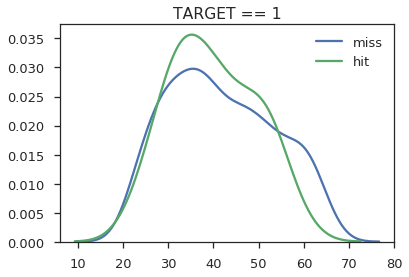

In [10]:
# Default ( cases )

sns.kdeplot(-df.loc[(df.target == 1) & (df.preds < .2), 'DAYS_BIRTH'] / 365, label='miss')
sns.kdeplot(-df.loc[(df.target == 1) & (df.preds >= .5), 'DAYS_BIRTH'] / 365, label='hit')

plt.title('TARGET == 1');

Looking at this we have realized that we are not able to perform very well with older people, we mark them as low risk but in fact they are high risk credits.

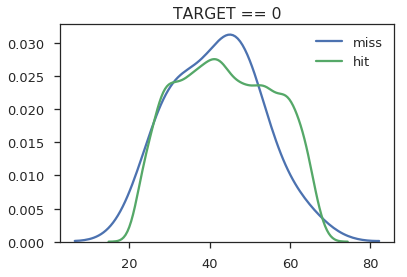

In [11]:
# No Default

sns.kdeplot(-df.loc[(df.target == 0) & (df.preds > .5), 'DAYS_BIRTH'] / 365, label='miss')
sns.kdeplot(-df.loc[(df.target == 0) & (df.preds < .2), 'DAYS_BIRTH'] / 365, label='hit')
plt.title('TARGET == 0');

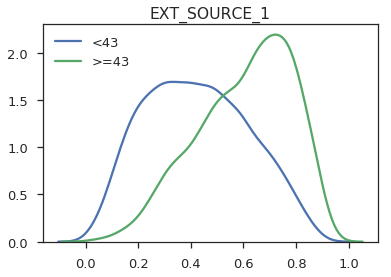

In [9]:
x = df.loc[:, ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
x.loc[:, 'age'] = -(x.DAYS_BIRTH / 365)
x.loc[:, 'emp'] = -(x.DAYS_EMPLOYED.replace({365243: np.nan}) / 365)


sns.kdeplot(x[x.age < 43]['EXT_SOURCE_1'], label='<43')
sns.kdeplot(x[x.age >= 43]['EXT_SOURCE_1'], label='>=43')
plt.title('EXT_SOURCE_1');

Completely different distribution for EXT_SOURCE_1 for different age threshold and the reason 

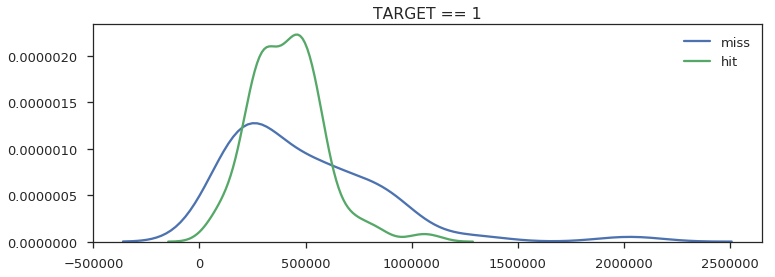

In [25]:
# Default
plt.figure(figsize=(12, 4))
sns.kdeplot(df.loc[(df.target == 1) & (df.preds < .05), 'AMT_CREDIT'], label='miss')
sns.kdeplot(df.loc[(df.target == 1) & (df.preds >= .3), 'AMT_CREDIT'], label='hit')
plt.title('TARGET == 1');

#### Name Income Type

In [7]:
# errors
df.loc[(df.target == 1) & (df.preds < .2), 'NAME_INCOME_TYPE'].value_counts(normalize=True)

Working                 0.562753
Commercial associate    0.232794
Pensioner               0.153846
State servant           0.050607
Unemployed              0.000000
Student                 0.000000
Maternity leave         0.000000
Businessman             0.000000
Name: NAME_INCOME_TYPE, dtype: float64

In [8]:
df.loc[(df.target == 1) & (df.preds > .5), 'NAME_INCOME_TYPE'].value_counts(normalize=True)

Working                 0.645161
Commercial associate    0.290323
State servant           0.032258
Pensioner               0.032258
Unemployed              0.000000
Student                 0.000000
Maternity leave         0.000000
Businessman             0.000000
Name: NAME_INCOME_TYPE, dtype: float64

Looks like Pensioners are considered as low risk credits by our model but they are actually high risk loanee.

In [8]:
df.columns.tolist()

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'CODE_GENDER',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT

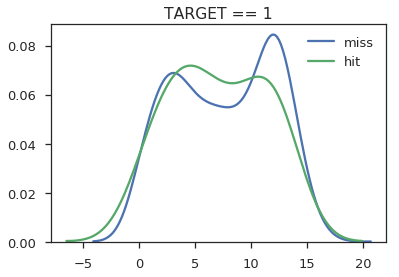

In [9]:
sns.kdeplot(-df.loc[(df.target == 1) & (df.preds < .2), 'DAYS_ID_PUBLISH'] / 365, label='miss')
sns.kdeplot(-df.loc[(df.target == 1) & (df.preds >= .5), 'DAYS_ID_PUBLISH'] / 365, label='hit')

plt.title('TARGET == 1');

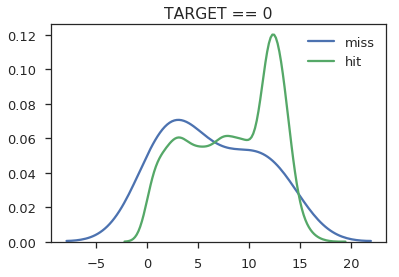

In [10]:
sns.kdeplot(-df.loc[(df.target == 0) & (df.preds > .5), 'DAYS_ID_PUBLISH'] / 365, label='miss')
sns.kdeplot(-df.loc[(df.target == 0) & (df.preds < .2), 'DAYS_ID_PUBLISH'] / 365, label='hit')

plt.title('TARGET == 0');

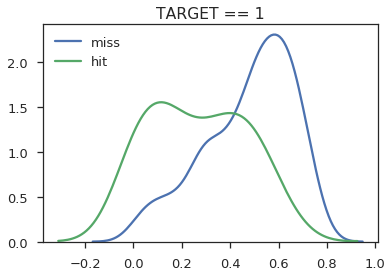

In [11]:
sns.kdeplot(df.loc[(df.target == 1) & (df.preds < .2), 'EXT_SOURCE_2'], label='miss')
sns.kdeplot(df.loc[(df.target == 1) & (df.preds >= .5), 'EXT_SOURCE_2'], label='hit')

plt.title('TARGET == 1');

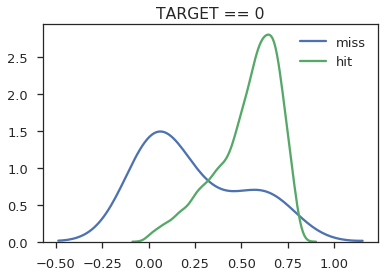

In [12]:
sns.kdeplot(df.loc[(df.target == 0) & (df.preds > .5), 'EXT_SOURCE_2'], label='miss')
sns.kdeplot(df.loc[(df.target == 0) & (df.preds < .2), 'EXT_SOURCE_2'], label='hit')

plt.title('TARGET == 0');

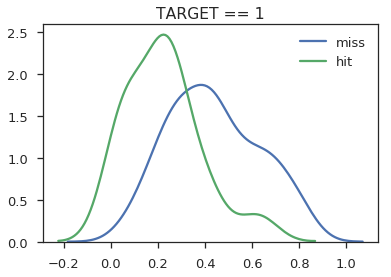

In [13]:
sns.kdeplot(df.loc[(df.target == 1) & (df.preds < .2), 'EXT_SOURCE_1'], label='miss')
sns.kdeplot(df.loc[(df.target == 1) & (df.preds >= .5), 'EXT_SOURCE_1'], label='hit')

plt.title('TARGET == 1');

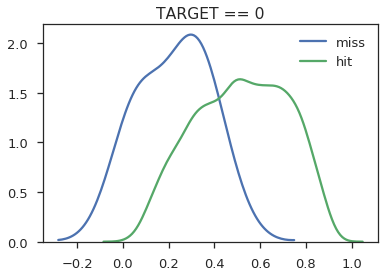

In [14]:
sns.kdeplot(df.loc[(df.target == 0) & (df.preds > .5), 'EXT_SOURCE_1'], label='miss')
sns.kdeplot(df.loc[(df.target == 0) & (df.preds < .2), 'EXT_SOURCE_1'], label='hit')

plt.title('TARGET == 0');

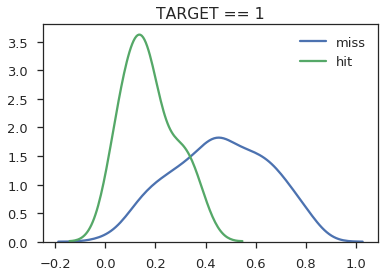

In [15]:
sns.kdeplot(df.loc[(df.target == 1) & (df.preds < .2), 'EXT_SOURCE_3'], label='miss')
sns.kdeplot(df.loc[(df.target == 1) & (df.preds >= .5), 'EXT_SOURCE_3'], label='hit')

plt.title('TARGET == 1');

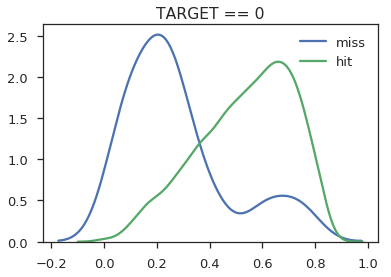

In [16]:
sns.kdeplot(df.loc[(df.target == 0) & (df.preds > .5), 'EXT_SOURCE_3'], label='miss')
sns.kdeplot(df.loc[(df.target == 0) & (df.preds < .2), 'EXT_SOURCE_3'], label='hit')

plt.title('TARGET == 0');

### Correlated features

In [3]:
data     = pd.read_hdf('../data/interim/dataset2/data.h5', key='data')
v86_feat = np.load('../data/interim/dataset2/v86_features.npy')

In [12]:
%%time

corr = data.loc[:, list(v86_feat) + ['TARGET']].iloc[:307511].corr()

CPU times: user 6min 17s, sys: 752 ms, total: 6min 18s
Wall time: 6min 18s


In [14]:
corr.to_csv('../data/tmp/corr.csv', index=True)

### OOF Preds

In [39]:
%%time 

data     = pd.read_hdf('../data/interim/dataset2/data.h5', key='data')
v86_feat = np.load('../data/interim/dataset2/v86_features.npy')

# sample
data     = data.iloc[:307511].sample(n=5000, random_state=SEED)
df, y     = data.loc[:, v86_feat], data.TARGET

del data
gc.collect();

CPU times: user 4.44 s, sys: 1.05 s, total: 5.48 s
Wall time: 5.49 s


In [71]:
Xtr, Xte, ytr, yte = train_test_split(df, y, test_size=.2, random_state=SEED)

In [72]:
m = xgb.XGBClassifier(objective='binary:logistic',
                       max_depth=4,
                       n_estimators=800, 
                       learning_rate=.1, 
                       colsample_bytree=.1, 
                       gamma=5,
                       n_jobs=-1,
                       random_state=SEED
                      )


cv        = KFold(n_splits=5, shuffle=True, random_state=SEED)
oof_preds = cross_val_predict(m, Xtr, ytr, method='predict_proba', cv=cv)

m.fit(Xtr, ytr)
val_preds = m.predict_proba(Xte)[:, 1]

In [73]:
# without new features score on holdout set

m = lgb.LGBMClassifier(objective='binary',
                       max_depth=4,
                       num_leaves=15,
                       n_estimators=800, 
                       learning_rate=.1, 
                       colsample_bytree=.1, 
                       reg_lambda=20,
                       min_child_weight=10,
                       random_state=SEED
                      )

m.fit(Xtr, ytr)
val_preds = m.predict_proba(Xte)[:, 1]

roc_auc_score(yte, val_preds)

0.7346603260869566

In [74]:
Xtr.loc[:, 'ratio_ext_source_1_preds'] = Xtr['EXT_SOURCE_1'] / oof_preds[:, 1]
Xtr.loc[:, 'ratio_ext_source_2_preds'] = Xtr['EXT_SOURCE_2'] / oof_preds[:, 1]
Xtr.loc[:, 'ratio_ext_source_3_preds'] = Xtr['EXT_SOURCE_3'] / oof_preds[:, 1]

Xtr.loc[:, 'diff_ext_source_1_preds'] = Xtr['EXT_SOURCE_1'] - oof_preds[:, 1]
Xtr.loc[:, 'diff_ext_source_2_preds'] = Xtr['EXT_SOURCE_2'] - oof_preds[:, 1]
Xtr.loc[:, 'diff_ext_source_3_preds'] = Xtr['EXT_SOURCE_3'] - oof_preds[:, 1]

In [75]:
Xte.loc[:, 'ratio_ext_source_1_preds'] = Xte['EXT_SOURCE_1'] / val_preds
Xte.loc[:, 'ratio_ext_source_2_preds'] = Xte['EXT_SOURCE_2'] / val_preds
Xte.loc[:, 'ratio_ext_source_3_preds'] = Xte['EXT_SOURCE_3'] / val_preds

Xte.loc[:, 'diff_ext_source_1_preds'] = Xte['EXT_SOURCE_1'] - val_preds
Xte.loc[:, 'diff_ext_source_2_preds'] = Xte['EXT_SOURCE_2'] - val_preds
Xte.loc[:, 'diff_ext_source_3_preds'] = Xte['EXT_SOURCE_3'] - val_preds

In [76]:
m.fit(Xtr, ytr)
new_val_preds = m.predict_proba(Xte)[:, 1]

roc_auc_score(yte, new_val_preds)

0.7126630434782609

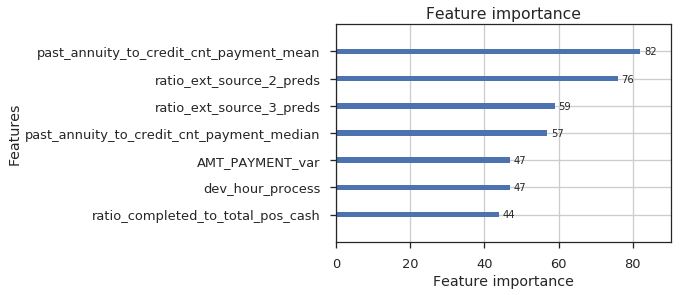

In [77]:
lgb.plot_importance(m.booster_, max_num_features=7)

### XGBoost Leaves

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [59]:
class XGBoostLeaves(BaseEstimator, ClassifierMixin):
    params = {
        'objective': 'binary:logistic',
        'eta': .01,
        'max_depth': 2,
        'colsample_bytree': .1,
        'min_child_weight': 20,
        'gamma': 5,
        'nthread': 4,
        'silent': 1
    }

    def __init__(self, num_leaves):
        self.num_leaves = num_leaves

    def fit(self, X, y=None):
        dtrain     = xgb.DMatrix(X, y)
        self.model = xgb.train(self.params, dtrain, self.num_leaves)

    def predict(self, X):
        return self.model.predict(xgb.DMatrix(X), pred_leaf=True)

In [60]:
%%time 

data     = pd.read_hdf('../data/interim/dataset2/data.h5', key='data')
v86_feat = np.load('../data/interim/dataset2/v86_features.npy')

# sample
data     = data.iloc[:307511].sample(n=5000, random_state=SEED)
df, y     = data.loc[:, v86_feat], data.TARGET

del data
gc.collect();

CPU times: user 4.56 s, sys: 1.05 s, total: 5.61 s
Wall time: 5.61 s


In [61]:
# split into training and test set
Xtr, Xte, ytr, yte = train_test_split(df, y, test_size=.2, random_state=SEED)

In [62]:
%%time

num_leaves = 20
fte        = XGBoostLeaves(num_leaves)
train_fte  = cross_val_predict(fte, Xtr, ytr, cv=3)

fte.fit(Xtr, ytr)
test_fte  = fte.predict(Xte)

CPU times: user 1.84 s, sys: 3.74 ms, total: 1.84 s
Wall time: 650 ms


In [63]:
# without leaves from XGBoost

m = lgb.LGBMClassifier(objective='binary',
                       max_depth=4,
                       num_leaves=15,
                       n_estimators=800, 
                       learning_rate=.1, 
                       colsample_bytree=.1, 
                       reg_lambda=20,
                       min_child_weight=10,
                       random_state=SEED
                      )

m.fit(Xtr, ytr)
val_preds = m.predict_proba(Xte)[:, 1]

roc_auc_score(yte, val_preds)

0.7346603260869566

In [64]:
train_fte_df = pd.DataFrame(train_fte, columns=[f'leaf_{i}' for i in range(train_fte.shape[1])])
train_fte_df.index = Xtr.index

test_fte_df = pd.DataFrame(test_fte, columns=[f'leaf_{i}' for i in range(test_fte.shape[1])])
test_fte_df.index = Xte.index

Xtr_new      = pd.concat((Xtr, train_fte_df), axis=1)
Xte_new      = pd.concat((Xte, test_fte_df), axis=1)

In [65]:
m = lgb.LGBMClassifier(objective='binary',
                       max_depth=4,
                       num_leaves=15,
                       n_estimators=800, 
                       learning_rate=.1, 
                       colsample_bytree=.1, 
                       reg_lambda=20,
                       min_child_weight=10,
                       random_state=SEED
                      )

m.fit(Xtr_new, ytr)
val_preds = m.predict_proba(Xte_new)[:, 1]

roc_auc_score(yte, val_preds)

0.7244429347826087

In [51]:
feat_df.loc[feat_df.feat.isin([c for c in feat_df.feat if 'leaf_' in c])]

,feat,imp
571,leaf_0,3
572,leaf_1,2
573,leaf_2,2
574,leaf_3,2
575,leaf_4,1
576,leaf_5,3
577,leaf_6,3
578,leaf_7,1
579,leaf_8,6
580,leaf_9,7


In [35]:
feat_df = pd.DataFrame({'feat': Xtr_new.columns, 'imp': m.feature_importances_})
feat_df.sort_values(by='imp', ascending=False)

,feat,imp
21,past_annuity_to_credit_cnt_payment_mean,69
131,dev_hour_process,55
369,past_annuity_to_credit_cnt_payment_median,53
409,CNT_INSTALMENT_FUTURE_sum,49
109,pca_0,49
293,ratio_age_employed,45
203,region_ext_source_3,44
267,diff_reg_age,42
346,ratio_completed_to_total_pos_cash,40
450,closed_credit_duration,39


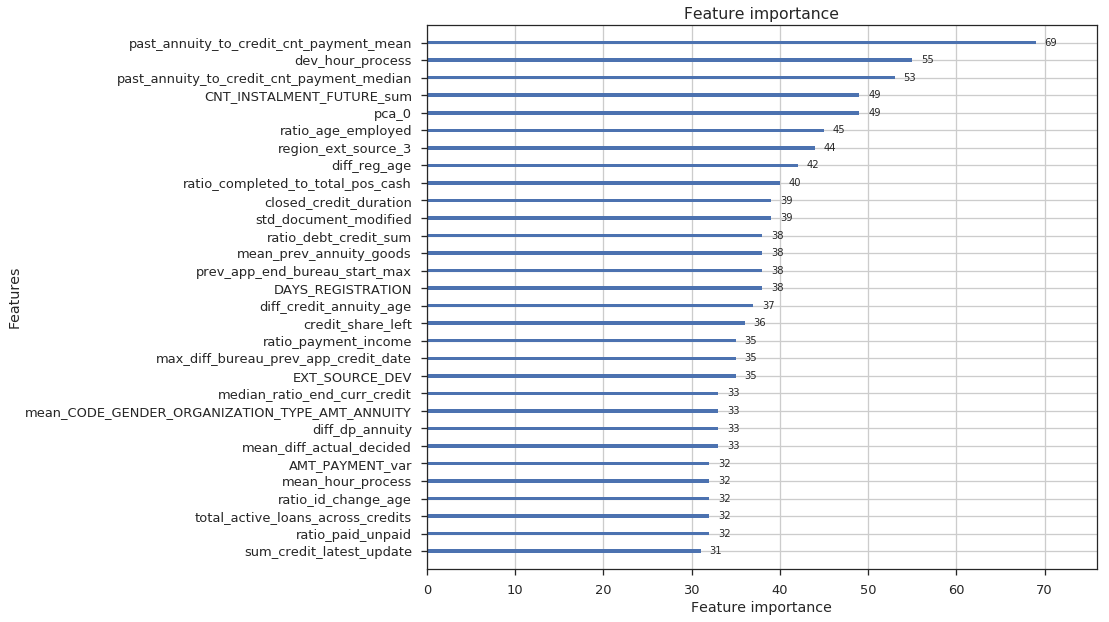

In [30]:
fig, ax = plt.subplots(figsize=(12, 10))
lgb.plot_importance(m.booster_, max_num_features=30, ax=ax);